# IT3100 - AI Applications Assignment

**Admin number:** 233517S <br>
**Name:** Yi Jiaxin <br>
**Class:** IT3100-2 <br>

This `.ipynb` notebook serves the purpose of generating datasets for training for the YOLOv11 model.

Revising the previous dataset, we had 200 classes with about 500 images each to label, which far exceeded our computational capabilities. Even through CLIP Embedding transformers to get the top 20 and reducing the image resolution, it still was far from sufficient to label them all at a minimum hardware cost, even while using A100 and H100s.

On top of that, the images were 27GB to unzip each time, which exceeded the storage limit on most platforms. As such, the last resort was to change the dataset used.

In this notebook, we will be using the [Freiburg Groceries Dataset](http://aisdatasets.informatik.uni-freiburg.de/freiburg_groceries_dataset/), provisioned by the University of Freiburg. It contains 25 classes of commonly seen items in supermarkets.

However, there was a new problem.

The summarised workflow would be as follow:

1. Download, unzip and visualize the images.
2. Train a YOLO model based on the images that have been already labelled.
3. Export the model in TFLite format.

## Step 1 - Unzip the data and import the libraries

Run the codes below to unzip the data, and format them into the respective directories.

An improvement made here is that the output is redirected to `/dev/null`, and thus the output does not flood the cells.

In [1]:
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
from ultralytics import YOLO

import zipfile
import os
import yaml

In [10]:
zip_path = "freiburg-groceries.v1i.yolov11.zip"
extract_dir = "freiburg_groceries_labelled"  # Directory to extract to

os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted '{zip_path}' to '{extract_dir}'")

# Visualize the folder hierarchy
def print_tree(startpath, prefix=""):
    for item in os.listdir(startpath):
        path = os.path.join(startpath, item)
        if os.path.isdir(path):
            print(prefix + "├── " + item + "/")
            print_tree(path, prefix + "│   ")
        else:
            print(prefix + "├── " + item)

print("\nDirectory structure:")
print_tree(extract_dir)

Extracted 'freiburg-groceries.v1i.yolov11.zip' to 'freiburg_groceries_labelled'

Directory structure:
├── data.yaml
├── test/
│   ├── images/
│   │   ├── TEA0049_png.rf.bcefeccc863b98b85bf2a738840c8927.jpg
│   │   ├── SUGAR0085_png.rf.004faeb8ecbeb6d1fe6174f229f3212d.jpg
│   │   ├── HONEY0151_png.rf.01b8ba5e5ea99a07ab722d85f59d448c.jpg
│   │   ├── SODA0093_png.rf.3cc91f0f0e615af377a037398662d29e.jpg
│   │   ├── JUICE0058_png.rf.3b538d5071364099bf5e7f2d938a6196.jpg
│   │   ├── JAM0093_png.rf.ec7ebb8c0dd3cfa122b15550c2c2380b.jpg
│   │   ├── JUICE0151_png.rf.5eeb75ec363ecfc057738d012ceda7be.jpg
│   │   ├── OIL0058_png.rf.7897065c4ba361149101cb232b82a7fe.jpg
│   │   ├── BEANS0026_png.rf.0a74e9172ad94abfdee5d2649df88c05.jpg
│   │   ├── JAM0053_png.rf.12bcbaf4513d9e52307d248ec5bf7d80.jpg
│   │   ├── SPICES0083_png.rf.7dff80960a8ef7d0ae6371fdf32f2293.jpg
│   │   ├── JUICE0271_png.rf.59aecf27a4fe1fa39f1ff63427642e5a.jpg
│   │   ├── NUTS0022_png.rf.0c7610039930acb5f6ed9346f0876e98.jpg
│   │   ├

Let us also check the content of the `data.yaml` file that will be used for training the YOLOv11 model.

In [11]:
yaml_path = "freiburg_groceries_labelled/data.yaml"
for root, dirs, files in os.walk(extract_dir):
    for file in files:
        if file == "data.yaml":
            yaml_path = os.path.join(root, file)
            break
    if yaml_path:
        break

if yaml_path:
    with open(yaml_path, "r") as f:
        data_yaml = yaml.safe_load(f)
    print(f"Contents of '{yaml_path}':\n")
    print(yaml.dump(data_yaml, sort_keys=False))
else:
    print("data.yaml not found in the extracted directory.")

Contents of 'freiburg_groceries_labelled/data.yaml':

train: ../train/images
val: ../valid/images
test: ../test/images
nc: 25
names:
- beans
- cake
- candy
- cereal
- chips
- chocolate
- coffee
- corn
- fish
- flour
- honey
- jam
- juice
- milk
- nuts
- oil
- pasta
- rice
- soda
- spices
- sugar
- tea
- tomato_sauce
- vinegar
- water
roboflow:
  workspace: main-jo0jy
  project: freiburg-groceries-tzdzv
  version: 1
  license: CC BY 4.0
  url: https://app.roboflow.com/main-jo0jy/freiburg-groceries-tzdzv/1



With the images unzipped and directory paths fixed, let's also quickly see if the annoations are largely correct.

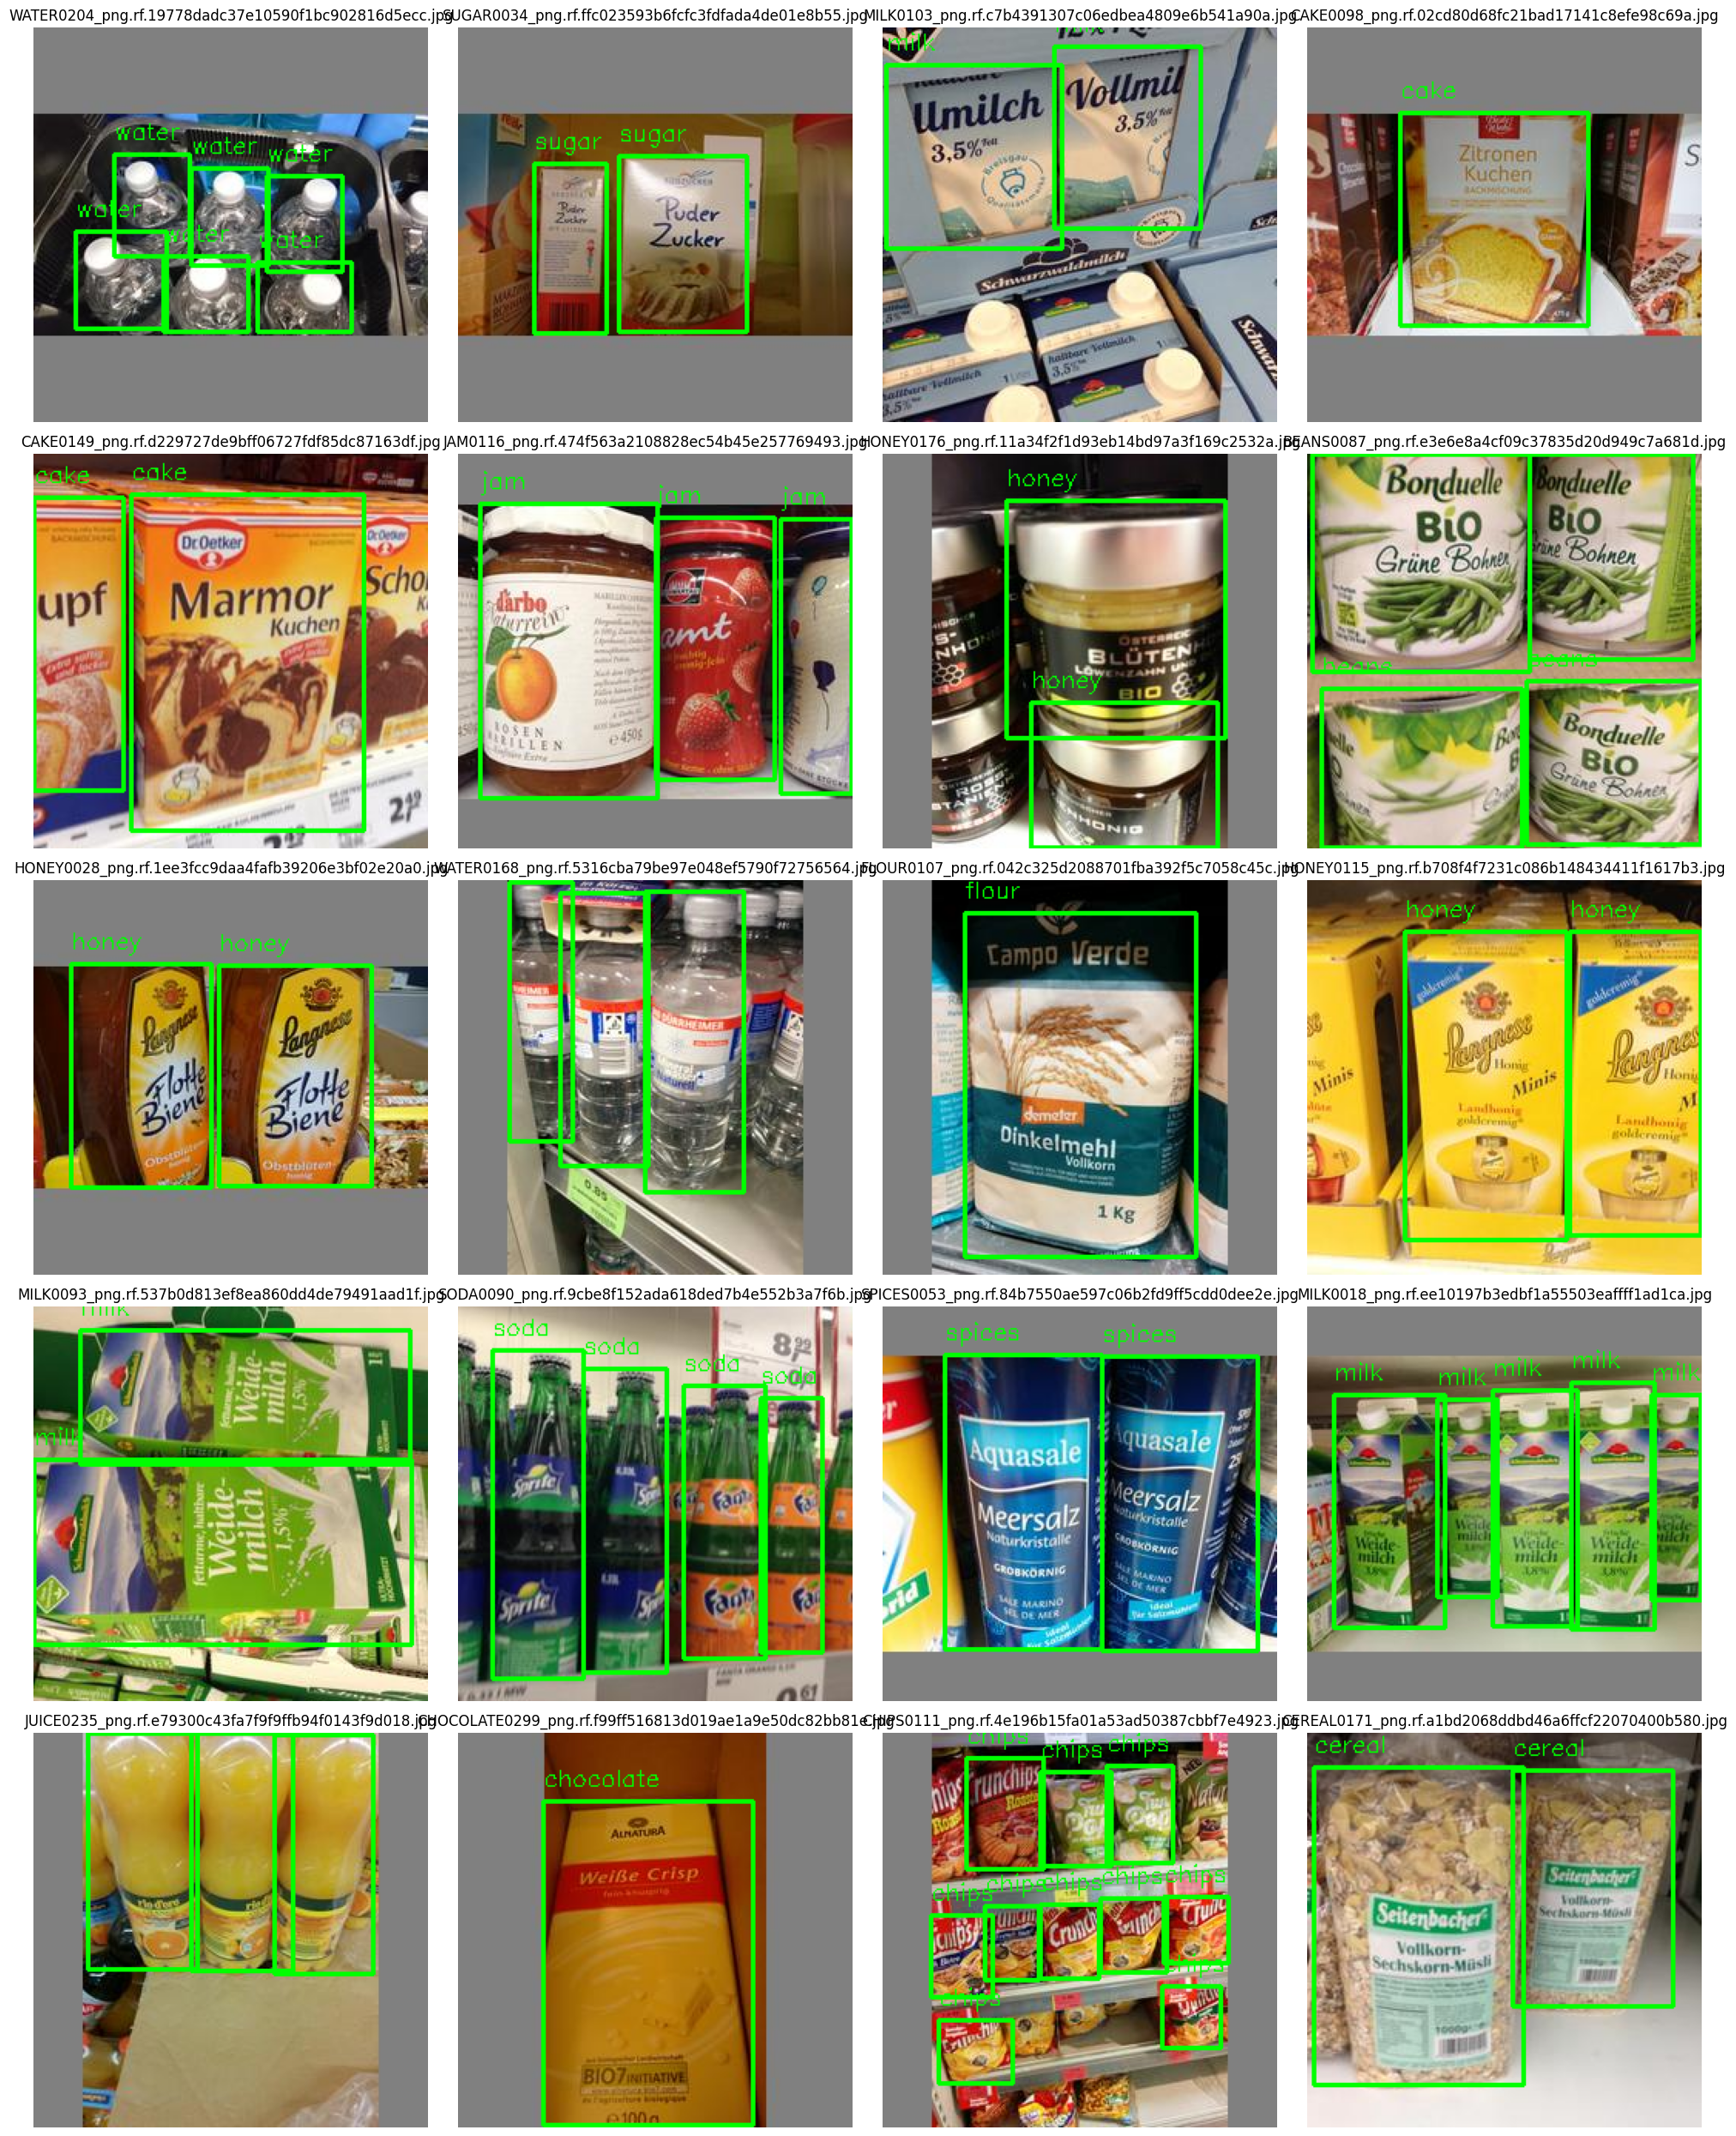

In [5]:
def visualize_annotations(data_yaml_path, num_samples=20):
    # Load the data.yaml to get class names and dataset paths
    with open(data_yaml_path, 'r') as f:
        data = yaml.safe_load(f)
    
    class_names = data['names']
    train_path = data['train']
    
    # Get all image files from train directory
    # Remove the extra 'images' since train_path already points to train/images
    image_dir = train_path
    label_dir = train_path.replace('/images', '/labels')
    
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # Randomly sample images
    sampled_images = random.sample(image_files, min(num_samples, len(image_files)))
    
    # Create subplots
    cols = 4
    rows = (len(sampled_images) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
    axes = axes.flatten() if rows > 1 else [axes] if rows == 1 else []
    
    for idx, image_file in enumerate(sampled_images):
        # Load image
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]
        
        # Load corresponding label file
        label_file = os.path.splitext(image_file)[0] + '.txt'
        label_path = os.path.join(label_dir, label_file)
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
            
            # Draw bounding boxes
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 5:
                    class_id = int(parts[0])
                    x_center, y_center, width, height = map(float, parts[1:5])
                    
                    # Convert YOLO format to pixel coordinates
                    x_center *= w
                    y_center *= h
                    width *= w
                    height *= h
                    
                    x1 = int(x_center - width / 2)
                    y1 = int(y_center - height / 2)
                    x2 = int(x_center + width / 2)
                    y2 = int(y_center + height / 2)
                    
                    # Draw bounding box
                    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    
                    # Add class label
                    class_name = class_names[class_id] if class_id < len(class_names) else f"Class_{class_id}"
                    cv2.putText(image, class_name, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        
        # Display image
        if idx < len(axes):
            axes[idx].imshow(image)
            axes[idx].set_title(f"{image_file}")
            axes[idx].axis('off')
    
    # Hide unused subplots
    for idx in range(len(sampled_images), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize annotations
if yaml_path:
    visualize_annotations(yaml_path, num_samples=20)
else:
    print("data.yaml not found. Please run previous cells first.")

## Step 2 - Training a YOLO model

With the dataset mostly intact and readily labelled, we can start training the YOLO model.

In [ ]:
# Load a YOLOv8 model (you can pick from nano/small/medium/large/xlarge)
model = YOLO("yolo11n.pt")

# Train the model
model.train(
    data="freiburg_groceries_labelled/data.yaml",   # path to your dataset yaml
    epochs=50,         # number of training epochs
    imgsz=256,          # input image size
    batch=16,           # batch size
    device='cpu',           # 0 = first GPU, 'cpu' = CPU only
    workers=4,          # dataloader workers
    project="runs/train",  # save dir
    name="yolov11-grocery" # experiment name
)

# Evaluate on validation set
metrics = model.val()

# Run inference on a test image
results = model("freifreiburg_groceries_labelled/test/images/BEANS0003_png.rf.b917141d6d9540ecddd79e10295d1934.jpg")
results.show()

New https://pypi.org/project/ultralytics/8.3.183 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.182 🚀 Python-3.12.3 torch-2.8.0+cu128 CPU (13th Gen Intel Core(TM) i5-13500H)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=freiburg_groceries_labelled/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov11-grocery4, nbs=64, nms=Fa

train: Scanning /home/xiaoxin/GitHub/Shelflytics/yolov11-mobile-model/freiburg_groceries_labelled/train/labels... 3946 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3946/3946 [00:03<00:00, 999.15it/s] 


train: New cache created: /home/xiaoxin/GitHub/Shelflytics/yolov11-mobile-model/freiburg_groceries_labelled/train/labels.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 752.8±232.4 MB/s, size: 12.2 KB)


/home/xiaoxin/PycharmProjects/Playground/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning /home/xiaoxin/GitHub/Shelflytics/yolov11-mobile-model/freiburg_groceries_labelled/valid/labels... 493 images, 0 backgrounds, 0 corrupt: 100%|██████████| 493/493 [00:00<00:00, 787.81it/s] 

val: New cache created: /home/xiaoxin/GitHub/Shelflytics/yolov11-mobile-model/freiburg_groceries_labelled/valid/labels.cache



/home/xiaoxin/PycharmProjects/Playground/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Plotting labels to runs/train/yolov11-grocery4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000345, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 0 dataloader workers
Logging results to runs/train/yolov11-grocery4
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/247 [00:00<?, ?it/s]

In [ ]:
model.export(
    format="tflite",
    imgsz=256,     # smaller input size speeds up inference
    half=False,    # don't use FP16
    int8=False     # don't use INT8 quantization
)